In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, combinations
import libpysal.weights as lpw

from scipy.optimize import minimize

In [89]:
import SARfunctions as sf

# Exponential Covariance Function

## 1. Calculate Covariance using exponential function

$$ Cov[Y_i, Y_j|X] = \theta_1 exp(-\theta_2 ||X_i - X_j||) =exp(-\frac{1}{2}|X_i - X_j|^2) $$ 

In [90]:
# set seed
seed_value = 42
np.random.seed(seed_value)

In [91]:
# make coordinates
N = 20
coords = sf.make_coords(N, 0, 10, 0, 10)

In [92]:
# calculate distances between coordinates
distances = sf.distances(coords)     
distances = sf.pairs_df(distances)

In [93]:
def exp_cov(params, distance): 
    theta1, theta2 = params
    return np.exp(-1/2*(distance**2))
    

In [94]:
# calculate covariance using exponential function
true_params = [1, -1/2]
cov_model = exp_cov(true_params, distances)
cov_model.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20
y1,1.000000e+00,8.834095e-13,1.013688e-05,0.003987,2.729648e-02,2.044221e-02,1.368470e-06,3.503433e-06,7.534321e-02,4.391442e-10,1.901415e-03,1.184370e-12,9.004297e-12,9.164450e-04,2.990378e-04,2.332739e-02,6.964820e-03,5.875287e-07,6.526526e-01,1.618497e-01
y2,8.834095e-13,1.000000e+00,2.852304e-02,0.000155,1.288243e-16,1.707809e-23,4.161904e-18,6.243122e-04,7.789986e-08,3.416326e-02,2.861604e-24,9.355999e-01,3.766300e-01,8.620618e-27,2.198176e-28,3.157079e-23,2.151823e-10,1.052199e-04,5.157694e-13,3.916531e-12
y3,1.013688e-05,2.852304e-02,1.000000e+00,0.312133,1.631872e-08,3.289862e-13,8.963281e-11,3.451239e-02,4.679491e-03,4.750623e-02,7.079171e-14,2.816214e-02,4.581884e-02,5.893644e-16,3.782513e-17,4.759990e-13,1.055475e-04,1.762657e-02,5.090510e-06,2.021680e-05
y4,3.986886e-03,1.552274e-04,3.121327e-01,1.000000,3.721201e-05,8.631630e-09,1.125008e-07,9.357284e-03,7.766944e-02,3.293718e-03,3.023233e-09,1.493826e-04,6.946205e-04,2.458645e-11,2.683908e-12,1.029546e-08,1.083810e-02,2.059341e-02,1.593578e-03,6.752158e-03
y5,2.729648e-02,1.288243e-16,1.631872e-08,0.000037,1.000000e+00,4.446948e-03,2.313256e-02,9.446854e-12,1.969725e-05,5.478596e-11,1.269005e-01,7.001885e-17,5.550848e-14,4.542840e-06,2.224513e-06,1.941629e-03,1.058787e-01,1.812453e-06,1.645539e-03,3.958332e-01


In [95]:
# make it into one dataframe of calculated covariance & distances
column_pairs = list(combinations(cov_model.columns, 2))

cov_pairs = [(cov_model[yi][yj]) for yi, yj in column_pairs]
dis_pairs = [(distances[yi][yj]) for yi, yj in column_pairs]

data = pd.DataFrame({'Calculated Covariance':cov_pairs, 'Distances': dis_pairs}, index=column_pairs)
data

,Calculated Covariance,Distances
"(y1, y2)",8.834095e-13,7.450502
"(y1, y3)",1.013688e-05,4.795692
"(y1, y4)",3.986886e-03,3.324077
"(y1, y5)",2.729648e-02,2.683653
"(y1, y6)",2.044221e-02,2.789320
...,...,...
"(y17, y19)",3.285114e-04,4.005231
"(y17, y20)",3.957374e-01,1.361620
"(y18, y19)",2.197450e-08,5.938583
"(y18, y20)",1.856977e-04,4.145212


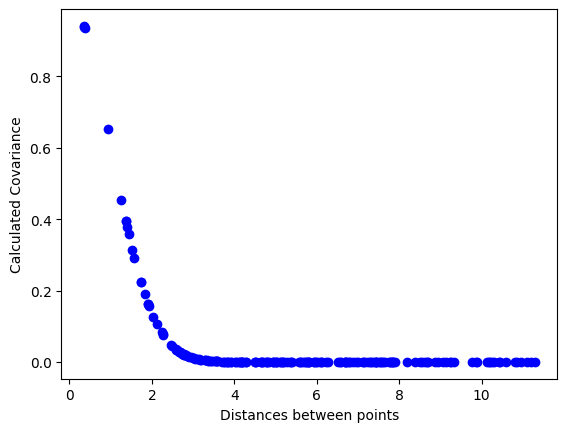

In [96]:
# plotting
plt.scatter(data['Distances'], data['Calculated Covariance'], c='blue')
# plt.yscale('log')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.show()

## 2. MLE for Exponential Covariance Function

* Assume that the covariance of observed data $\bold{Y} = \{Y_1, Y_2, ..., Y_n\}'$ follows the multivariate normal distribution $Cov(Y_i, Y_j) \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ 
* N: size of dimension, n: number of data points 
    * $\boldsymbol{\mu}$:  1 $\times$ $N \choose 2$ vector = (1, $N \choose 2$) array
    * $\boldsymbol{\Sigma}$: $N \choose 2$ $\times$ $N \choose 2$ matrix = ($N \choose 2$, $N \choose 2$) array
    * Random vector $Cov = \{Cov(Y_1, Y_2), ...,Cov(X_{N-1},X_{N}) \}'$:  n 1 $\times$ $N \choose 2$ vector = (n, 1, $N \choose 2$) array


$$ logL(\boldsymbol {\mu}, \boldsymbol {\Sigma})= l(\boldsymbol {\mu}, \boldsymbol {\Sigma}) = \sum^n_{i=1} -\frac{1}{2}(\boldsymbol{Cov}_{ij}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{Cov}_{ij}-\boldsymbol{\mu})-{\frac {1}{2}}log|{\boldsymbol {\Sigma }}|$$



$$\boldsymbol {Cov} = \theta_1 exp(-\theta_2 ||X_i - X_j||)$$

* $E[\boldsymbol{Cov}] = \theta_1 exp(-\theta_2 E[||X_i - X_j||])$
* $Cov[\boldsymbol{Cov}] = \theta_1 exp(-\theta_2 Cov[||X_i - X_j||])$

In [114]:
N = len(cov_pairs) # dimension of Cov
n = 100 # number of data points

In [116]:
Cov = cov_pairs

In [118]:
# initialize the parameters
mean_params = np.zeros(N)
cov_params = np.eye(N).flatten()

initial_params = np.concatenate((mean_params, cov_params))

In [122]:
def log_likelihood(params, data):
    mu = params[:N]
    Sigma = params[N:].reshape((N, N))
    n = len(data)
    
    inv_Sigma = np.linalg.inv(Sigma)
    log_det_Sigma = np.log(np.linalg.det(Sigma))
    
    logL = 0.0
    for i in range(n):
        x = data[i]
        logL += -0.5 * (x - mu).T @ inv_Sigma @ (x - mu) - 0.5 * log_det_Sigma
    return -logL

In [123]:
# minimize the negative log-likelihood to estimate the parameters
result = minimize(log_likelihood, initial_params, args=(Cov,))
estimated_params = result.x

/var/folders/q0/pmjpggzn2yqbzlw4r8fbvcsm0000gn/T/ipykernel_48857/3686841562.py:7: RuntimeWarning: invalid value encountered in log
  log_det_Sigma = np.log(np.linalg.det(Sigma))
/Users/yeonsoo/Desktop/research/RA-May2023/SARvenv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


KeyboardInterrupt: 